In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
# Cargamos los datos usando las fechas como índice
dataset = pd.read_csv('dataset/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=True)
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
# Separamos los datos de entrenamiento (hasta 2016) de los de test (2017)
# Sólo tomamos el valor de apertura de la sesión
training_set = dataset[:'2016'].iloc[:, 1:2]
test_set = dataset['2017':].iloc[:, 1:2]

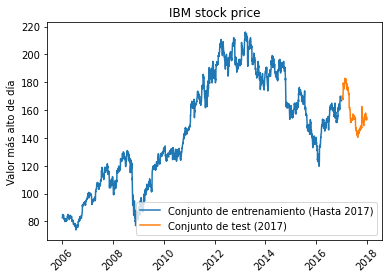

In [4]:
df_before2016=dataset["High"][:'2016']
df_2017=dataset["High"]['2017']
plt.plot(df_before2016)
plt.plot(df_2017)
plt.title('IBM stock price')
plt.legend(['Conjunto de entrenamiento (Hasta 2017)','Conjunto de test (2017)'])
plt.ylabel('Valor más alto de día')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Reescalamos el conjunto de entrenamiento
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [6]:
# Preparamos los datos para usar LSTM, a cada elemento de entrenamiento le damos los x anteriores como memoria.
memory=260
X_train = []
y_train = []
for i in range(memory, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-memory:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [7]:
# Preparamos los datos para la entrada de nuestra LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Diseño de nuestra LSTM
model = Sequential()

# Capa de entrada
model.add(LSTM(units=5, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Capa intermedia 1
model.add(LSTM(units=5, return_sequences=True))
model.add(Dropout(0.2))

# Capa intermedia 2
model.add(LSTM(units=5, return_sequences=True))
model.add(Dropout(0.2))

# Capa intermedia 3
model.add(LSTM(units=5))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(units=1))

# Compilando nuestra RNN
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Introducimos nuestros datos de entrenamiento
model.fit(X_train, y_train, epochs=10, batch_size=5)

Epoch 1/10
502/502 [==============================] - 173s 344ms/step - loss: 0.0340
Epoch 2/10
138/502 [=======>......................] - ETA: 2:00 - loss: 0.0142

In [ ]:
# día a día

# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
#dataset_total = pd.concat((dataset["High"][:'2016'], dataset["High"]['2017':]), axis=0)
#inputs = dataset_total[len(dataset_total) - len(test_set) - memory:].values
#inputs = inputs.reshape(-1, 1)
#inputs = scaler.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
#X_test = []
#for i in range(memory, len(inputs)):
#    X_test.append(inputs[i-memory:i, 0])
#X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#
#predicted_stock_price = model.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [ ]:
dataset_total = pd.concat((dataset["High"][:'2016'], dataset["High"]['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - memory:len(dataset_total) - len(test_set)].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [ ]:
X_test = []
X_test.append(inputs)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = np.array(model.predict(X_test))
print(predicted_stock_price[0])

for i in range(1, len(test_set)):
    X_test = []
    inputs = np.vstack([inputs, predicted_stock_price[i-1]])
    X_test.append(inputs[i:])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = np.vstack([predicted_stock_price, model.predict(X_test)])
    #print(predicted_stock_price[i])

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [ ]:
predicted_stock_price

In [ ]:
predicted_set = pd.DataFrame(data=predicted_stock_price, index=dataset['2017':].index, columns=['High'])

In [ ]:
plt.plot(test_set, color='red',label='Real IBM Stock Price')
plt.plot(predicted_set, color='blue',label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_set))
print("The root mean squared error is {}.".format(rmse))